<a href="https://colab.research.google.com/github/QuatZo/kickstarter-predictor/blob/master/Deep_Learning_Classifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries & dataset

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time
import statistics as stats
import requests
import pickle
import json

from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.base import clone
from sklearn.externals.joblib import dump, load

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler

df = pd.read_csv('http://puma.swstats.info/files/kickstarter_with_trends.csv', index_col="ID")
df.columns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functio

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'tokenized_name', 'trend'],
      dtype='object')

# Prepare for data cleaning

In [0]:
link = 'https://3l7z4wecia.execute-api.us-east-1.amazonaws.com/default/api-dynamodb/'

get_categories = {
  "operation": "list",
  "table": "categories",
}

categories = requests.post(link, json=get_categories)

categories = categories.json()['Items']
categories_proper = dict()
for item in categories:
  categories_proper[item['name']] = item['id'] # map NAME to ID

get_main_categories = {
  "operation": "list",
  "table": "maincategories",
}

main_categories = requests.post(link, json=get_main_categories)

main_categories = main_categories.json()['Items']
main_categories_proper = dict()
for item in main_categories:
  main_categories_proper[item['name']] = item['id'] # map NAME to ID

get_countries = {
  "operation": "list",
  "table": "countries",
}

countries = requests.post(link, json=get_countries)

countries = countries.json()['Items']
countries_proper = dict()
for item in countries:
  countries_proper[item['name']] = item['id'] # map NAME to ID

# Clean & prepare data
* Calculate campaign length 
* Delete all incomplete data (like country == N,0")
* Delete all kickstarter projects with different state than 'failed' and 'successful' 
* Cast to numerical types all non-numerical features and drop all empty data
* Use Label Encoding or One-Hot Encoding

In [4]:
df_clean = df.copy()

indexes = df_clean[df_clean['country'] == 'N,0"'].index
df_clean.drop(indexes, inplace=True)
# drop live & undefined states
indexes = df_clean[(df_clean['state'] == 'live') | (df_clean['state'] == 'undefined')].index
df_clean.drop(indexes, inplace=True)

df_clean['campaign_length'] = pd.to_timedelta((pd.to_datetime(df_clean['deadline']) - pd.to_datetime(df_clean['launched'])), unit='days').dt.days
# df_clean = df_clean[(df_clean['usd_goal_real'] >= 10) & (df_clean['campaign_length'] >= 7)] # drop all with lower goal than 10$ and shorter than week

##########################################################
# """ Label Encoding - if you want to run this, just comment lines with quotation marks
jsons = dict()
map_dict = {
    'category': categories_proper,
    'main_category': main_categories_proper,
    'country': countries_proper,
}
for key, val in map_dict.items():
  df_clean[key] = df_clean[key].map(val)

json.dump(jsons, open('categories.json', 'w'))

df_clean.drop(['tokenized_name', 'currency', 'name'], inplace=True, axis=1)
df_clean.dropna(inplace=True)
# """
##########################################################

###########################################################
""" One-Hot Encoding - if you want to run this, just comment lines with quotation marks
column_transformer = ColumnTransformer([('encoder', OneHotEncoder(), ['category', 'main_category', 'currency', 'country'])], sparse_threshold=0, n_jobs=-1)
onehot = pd.DataFrame(column_transformer.fit_transform(df_clean)).set_index(df_clean.index)
new_cols_encoding = [col.replace('encoder__x0_', '').replace('encoder__x1_', '').replace('encoder__x2_', '').replace('encoder__x3_', '') for col in column_transformer.get_feature_names()]
onehot.columns = new_cols_encoding
df_clean = pd.concat([df_clean, onehot], axis=1)
df_clean.drop(['category', 'main_category', 'currency', 'country', 'tokenized_name'], inplace=True, axis=1)
df_clean = df_clean.loc[:,~df_clean.columns.duplicated()]
"""
##########################################################

df_xd = df_clean[~df_clean['state'].str.contains('successful')].index
df_clean.loc[df_clean['state'].str.contains('successful'), 'state'] = 1
df_clean.loc[df_xd, 'state'] = 0
df_clean['state'] = df_clean['state'].astype(int)


df_clean

,category,main_category,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,trend,campaign_length
ID,,,,,,,,,,,,,,
1000002330,0,0,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,0,0.0,0.0,1533.95,26.526034,58
1000003930,1,1,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,1,100.0,2421.0,30000.00,13.684380,59
1000004038,1,1,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,1,220.0,220.0,45000.00,35.000000,44
1000007540,2,2,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,1,1.0,1.0,5000.00,28.000000,29
1000011046,3,1,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,1,1283.0,1283.0,19500.00,21.800000,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999976400,8,1,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,0,1,1,25.0,25.0,50000.00,19.000000,29
999977640,1,1,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,0,5,1,155.0,155.0,1500.00,56.000000,26
999986353,1,1,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,0,1,1,20.0,20.0,15000.00,18.000000,45


# Check features correlation
We say features are dependant, if abs(correlation) > .5

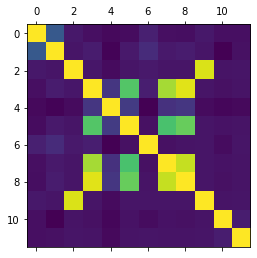

,category,main_category,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,trend,campaign_length
category,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
main_category,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
goal,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.941676,NaN,NaN
pledged,NaN,NaN,NaN,1.000000,NaN,0.718208,NaN,0.858153,0.953262,NaN,NaN,NaN
state,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backers,NaN,NaN,NaN,0.718208,NaN,1.000000,NaN,0.697767,0.753399,NaN,NaN,NaN
country,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
usd pledged,NaN,NaN,NaN,0.858153,NaN,0.697767,NaN,1.000000,0.908014,NaN,NaN,NaN
usd_pledged_real,NaN,NaN,NaN,0.953262,NaN,0.753399,NaN,0.908014,1.000000,NaN,NaN,NaN
usd_goal_real,NaN,NaN,0.941676,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN


In [5]:
corr = df_clean.corr()

plt.matshow(corr)
plt.show()

corr[(corr > .5) | (corr < -.5)]

# Delete unnecessary features
We delete dupe features (like converted goal value) and the ones that user won't be able to provide, like backers.

In [6]:
df_shortened = df_clean.copy()
df_shortened.drop(['pledged', 'backers', 'usd pledged', 'deadline', 'launched', 'usd_pledged_real', 'goal'], axis=1, inplace=True)
df_shortened

,category,main_category,state,country,usd_goal_real,trend,campaign_length
ID,,,,,,,
1000002330,0,0,0,0,1533.95,26.526034,58
1000003930,1,1,0,1,30000.00,13.684380,59
1000004038,1,1,0,1,45000.00,35.000000,44
1000007540,2,2,0,1,5000.00,28.000000,29
1000011046,3,1,0,1,19500.00,21.800000,55
...,...,...,...,...,...,...,...
999976400,8,1,0,1,50000.00,19.000000,29
999977640,1,1,0,1,1500.00,56.000000,26
999986353,1,1,0,1,15000.00,18.000000,45


# Split data
Split data for training & test set, with 10% being in test set. 30k is enough for testing.

In [7]:
X = df_shortened.drop('state', axis=1)
y = df_shortened['state']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=2137) # 90%:10%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=2137) # 81%:9% -> 90%
X_train

,category,main_category,country,usd_goal_real,trend,campaign_length
ID,,,,,,
1942408238,121,6,1,10000.00,10.000000,29
151688513,3,1,0,1680.87,18.200000,29
1202127605,27,11,1,60000.00,33.600000,23
1481031083,49,12,1,40000.00,38.500000,29
1354614493,117,9,2,23266.64,36.488323,59
...,...,...,...,...,...,...
696627033,19,9,1,1500.00,38.000000,40
259775964,46,1,1,5000.00,13.500000,29
2002951756,7,4,0,12945.99,42.000000,29


# Data Over/Undersampling

In [8]:
print(pd.Series(train_data['y']).value_counts())

NameError: ignored

In [9]:
def sample_data(sampler, X_train, y_train, cols):
    start = time.time()
    X_train_new, y_train_new = sampler.fit_sample(X_train, y_train)
    X_train_new = pd.DataFrame(X_train_new)
    X_train_new.columns = cols
    print(f"SMOTENC done in {round(time.time() - start, 2)} seconds")

    return {
      'x': X_train_new,
      'y': y_train_new,
    }


train_data = sample_data(SMOTENC([0, 1, 2], n_jobs=-1), X_train, y_train, X_train.columns)
test_data = { 'x': X_test, 'y': y_test }
val_data = { 'x': X_val, 'y': y_val }

print(pd.Series(train_data['y']).value_counts())
print(pd.Series(test_data['y']).value_counts())
print(pd.Series(val_data['y']).value_counts())


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTENC done in 538.48 seconds
1    192759
0    192759
dtype: int64
0    23913
1    13293
Name: state, dtype: int64
0    21532
1    11953
Name: state, dtype: int64


# (Optional) Delete all irrelevant features
Delete all irrelevant features, but keep AT MAX 5

In [10]:
""" If you want to use this cell, just comment lines with quotation marks at the beginning
logistic = LogisticRegression(C=1, penalty="l2", max_iter=1000).fit(X_train, y_train)
model = SelectFromModel(logistic, prefit=True, max_features=5)

X_new = model.transform(X_train)

selected_features = pd.DataFrame(model.inverse_transform(X_new), index=X_train.index, columns=X_train.columns)
selected_columns = selected_features.columns[selected_features.var() != 0]

X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

selected_features
"""

' If you want to use this cell, just comment lines with quotation marks at the beginning\nlogistic = LogisticRegression(C=1, penalty="l2", max_iter=1000).fit(X_train, y_train)\nmodel = SelectFromModel(logistic, prefit=True, max_features=5)\n\nX_new = model.transform(X_train)\n\nselected_features = pd.DataFrame(model.inverse_transform(X_new), index=X_train.index, columns=X_train.columns)\nselected_columns = selected_features.columns[selected_features.var() != 0]\n\nX_train = X_train[selected_columns]\nX_test = X_test[selected_columns]\n\nselected_features\n'

# Standarization & min-max scaling
Standarization -> mean-std

Min-Max scaling -> min-max

In [11]:
def standarize(X_train, X_test, X_val):
    cols = X_train.columns
    indexes_x_train = X_train.index
    indexes_x_test = X_test.index
    indexes_x_val = X_val.index

    X_train_categorical = X_train[['category', 'main_category', 'country']]
    X_test_categorical = X_test[['category', 'main_category', 'country']]
    X_val_categorical = X_val[['category', 'main_category', 'country']]

    scaler = StandardScaler()
    scaler.fit(X_train.drop(['category', 'main_category', 'country'], axis=1))
    
    X_train = pd.concat([X_train_categorical, pd.DataFrame(scaler.transform(X_train.drop(['category', 'main_category', 'country'], axis=1))).set_index(indexes_x_train)], axis=1)    
    X_test = pd.concat([X_test_categorical, pd.DataFrame(scaler.transform(X_test.drop(['category', 'main_category', 'country'], axis=1))).set_index(indexes_x_test)], axis=1)
    X_val = pd.concat([X_val_categorical, pd.DataFrame(scaler.transform(X_val.drop(['category', 'main_category', 'country'], axis=1))).set_index(indexes_x_val)], axis=1)
    
    X_train.columns = cols
    X_test.columns = cols
    X_val.columns = cols

    return X_train, X_test, X_val, scaler

train_data['x'], test_data['x'], val_data['x'], standarizer = standarize(train_data['x'], test_data['x'], val_data['x'])
test_data['x']

,category,main_category,country,usd_goal_real,trend,campaign_length
ID,,,,,,
152960477,28,2,1,-0.032425,1.431441,-0.061184
951135138,30,10,1,-0.036695,0.765281,-0.061184
2057049378,32,0,1,-0.034937,-1.043867,-0.045868
429002892,8,1,1,-0.002283,-1.066388,0.168559
655581038,46,1,1,-0.030415,0.017313,-0.045868
...,...,...,...,...,...,...
605794243,8,1,1,-0.012330,-0.762611,0.168559
1630168153,43,6,1,-0.029411,-0.581062,-0.061184
162940962,5,3,1,-0.027401,0.021988,-0.061184


# Load Standarizer (Scaler) from Web Server


#Deep Learning


In [12]:
! pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 5.0MB/s 
     |████████████████████████████████| 296kB 15.5MB/s 


In [36]:
from tensorflow_model_optimization.sparsity import keras as sparsity
l = tf.keras.layers
batch_size = 1024
epochs = 500
end_step = np.ceil(1.0 * train_data['x'].shape[0] / batch_size).astype(np.int32) * epochs
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.01,
                                                   final_sparsity=0.2,
                                                   begin_step=round(end_step/epochs/2),
                                                   end_step=end_step,
                                                   frequency=end_step/epochs)
}
tf.random.set_seed(2137)
pruned_model = tf.keras.Sequential([
    sparsity.prune_low_magnitude(
        tf.keras.layers.Dense(12, input_dim=train_data['x'].shape[1], activation='selu'),
        **pruning_params),
    l.BatchNormalization(),
    sparsity.prune_low_magnitude(
        tf.keras.layers.Dense(12, activation='relu'),**pruning_params),
    l.Flatten(),
    sparsity.prune_low_magnitude(
        tf.keras.layers.Dense(12*train_data['x'].shape[1], activation='selu'),**pruning_params),
    l.Dropout(0.001),
    sparsity.prune_low_magnitude(tf.keras.layers.Dense(1, activation='sigmoid'),
                                 **pruning_params)
])

pruned_model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_dense_28 (None, 12)                158       
_________________________________________________________________
batch_normalization_7 (Batch (None, 12)                48        
_________________________________________________________________
prune_low_magnitude_dense_29 (None, 12)                302       
_________________________________________________________________
flatten_7 (Flatten)          (None, 12)                0         
_________________________________________________________________
prune_low_magnitude_dense_30 (None, 72)                1802      
_________________________________________________________________
dropout_7 (Dropout)          (None, 72)                0         
_________________________________________________________________
prune_low_magnitude_dense_31 (None, 1)                

In [37]:
pruned_model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer='Adam',
    metrics=['accuracy'])

# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0)
]

pruned_model.fit(train_data['x'],train_data['y'],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks,
          validation_data=(val_data['x'],val_data['y']))

score = pruned_model.evaluate(test_data['x'],test_data['y'], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/500
377/377 [==============================] - 3s 8ms/step - loss: 0.6786 - accuracy: 0.5656 - val_loss: 0.6815 - val_accuracy: 0.5534
Epoch 2/500
377/377 [==============================] - 3s 8ms/step - loss: 0.6643 - accuracy: 0.5942 - val_loss: 0.6605 - val_accuracy: 0.5874
Epoch 3/500
377/377 [==============================] - 3s 8ms/step - loss: 0.6539 - accuracy: 0.6083 - val_loss: 0.6340 - val_accuracy: 0.6334
Epoch 4/500
377/377 [==============================] - 3s 8ms/step - loss: 0.6469 - accuracy: 0.6168 - val_loss: 0.6423 - val_accuracy: 0.6046
Epoch 5/500
377/377 [==============================] - 3s 8ms/step - loss: 0.6418 - accuracy: 0.6237 - val_loss: 0.6204 - val_accuracy: 0.6485
Epoch 6/500
377/377 [==============================] - 3s 8ms/step - loss: 0.6379 - accuracy: 0.6295 - val_loss: 0.6365 - val_accuracy: 0.6161
Epoch 7/500
377/377 [==============================] - 3s 8ms/step - loss: 0.6354 - accuracy: 0.6334 - val_loss: 0.6385 - val_accuracy: 0.6147

In [44]:
# Zapisanie modelu sieci
pruned_model.save('Model_Sieci_Glebokiego_Uczenia')

INFO:tensorflow:Assets written to: Model_Sieci_Glebokiego_Uczenia/assets


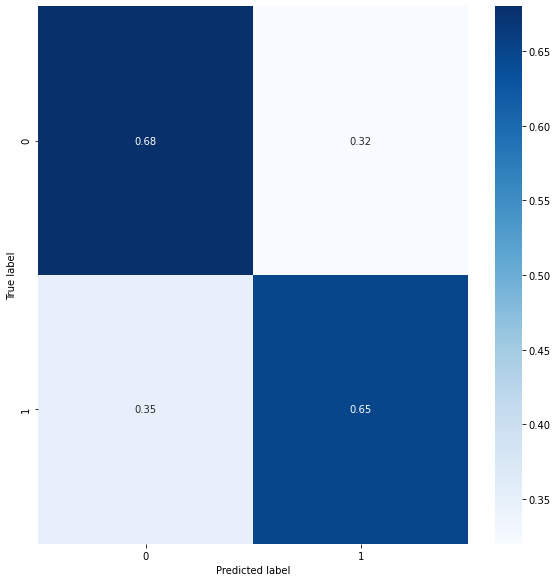

In [43]:
# Wczytanie modelu sieci
siec = tf.keras.models.load_model('Model_Sieci_Glebokiego_Uczenia')

import seaborn as sns
y_pred=siec.predict_classes(train_data['x'])
con_mat = tf.math.confusion_matrix(labels=train_data['y'], predictions=y_pred).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm)


figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()